In [ ]:
import torch
from dataset import collate_fn, get_dataset
from torch import nn
from torch.utils.data import DataLoader
from model import get_model, clip_loss
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score

In [56]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="../data/checkpoints/clip-model",
    num_train_epochs=40,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    warmup_steps=50,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_steps=10,
    save_strategy="epoch",
    optim="adamw_torch_fused",
    bf16=True if torch.cuda.is_available() else False,
    report_to="none",
    dataloader_num_workers=6,
)


In [106]:
def compute_sims(model, ds, device="cpu"):
    model.eval()
    all_image_embs = []
    all_texts = []

    with torch.no_grad():
        for imgs, texts in ds:
            imgs = imgs.to(device).unsqueeze(0)
            all_image_embs.append(model.project_images(imgs))
            all_texts.append(texts)  # mantém lista de strings

        # concatena embeddings de todas as imagens
        image_embs = torch.cat(all_image_embs, dim=0)  # (num_images, dim)

        # codifica todos os textos
        text_embs = model.project_texts(all_texts).to(device)  # (num_texts, dim)

        # matriz de similaridade coseno
        sims = torch.matmul(image_embs, text_embs.T)  # (num_images, num_texts)

    return sims

@torch.no_grad()
def compute_silhouette(model, ds, device):
    #Calcula o índice de silhueta com base nas similaridades entre
    #as 1000 primeiras e 1000 últimas imagens comparadas com todos os textos.

    # Similaridade coseno entre imagens e textos
    sims = compute_sims(model, ds, device)  # (num_images, num_texts)

    # Converte similaridade → distância exponencial
    dist = torch.exp(-sims.detach().cpu())

    # Normaliza [0, 1] antes do cálculo da silhueta
    dist = (dist - dist.min()) / (dist.max() - dist.min())

    # Inicializa a diagonal principal com zeros
    idx = torch.arange(dist.size(0))
    dist[idx, idx] = 0

    # cria rótulos (metade positivas, metade negativas)
    # ex: primeiros 1000 pares são positivos, últimos 1000 negativos
    n = dist.shape[0]
    half = n // 2
    labels = np.zeros(n)
    labels[:half] = 1  # primeiros = positivos

    # Calcula índice de silhueta
    score = silhouette_score(dist, labels, metric="precomputed")

    return score

In [107]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


# Configurações
device = "cuda" if torch.cuda.is_available() else "cpu"
model = get_model()
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

ds_train, ds_valid = get_dataset("../Graphs/data/images", "../Graphs/data/edgelists.json", split=0)
dl = torch.utils.data.DataLoader(ds_train,
                                 batch_size=training_args.per_device_train_batch_size,
                                 shuffle=True,
                                 num_workers=training_args.dataloader_num_workers, 
                                 collate_fn=collate_fn,)

optimizer = torch.optim.AdamW(model.parameters(),
                              lr=training_args.learning_rate,
                              weight_decay=training_args.weight_decay)

model.to(device)
model.train()

for epoch in range(int(training_args.num_train_epochs)):
    total_loss = 0
    for step, (imgs, texts) in enumerate(dl):
        imgs = imgs.to(device)

        # Tokeniza os textos do batch
        enc_texts = tokenizer(
            list(texts), padding=True, truncation=True, return_tensors="pt"
        ).to(device)

        optimizer.zero_grad()

        # logits = (batch_img, batch_text) → matriz (B, B)
        logits = model(imgs, list(texts))

        # CLIP loss (InfoNCE)
        loss = clip_loss(logits)
        loss.backward()

        # grad accumulation
        if (step + 1) % training_args.gradient_accumulation_steps == 0:
            optimizer.step()

        total_loss += loss.item()

    # logging
    avg_loss = total_loss / len(dl)
    print(f"Epoch {epoch+1}/{training_args.num_train_epochs}, Loss média: {avg_loss:.4f}")

    sil_score = compute_silhouette(model, ds_train, device=device)
    print(f"Silhueta: {sil_score:.4f}\n")


Device set to use cpu


Epoch 1/40, Loss média: 2.1109
Silhueta: 0.0090

Epoch 2/40, Loss média: 2.0761
Silhueta: 0.0763

Epoch 3/40, Loss média: 2.0392
Silhueta: 0.1911

Epoch 4/40, Loss média: 1.9581
Silhueta: 0.1510

Epoch 5/40, Loss média: 1.5202
Silhueta: 0.2499

Epoch 6/40, Loss média: 1.0520
Silhueta: 0.2176

Epoch 7/40, Loss média: 0.8583
Silhueta: 0.2296

Epoch 8/40, Loss média: 0.7266
Silhueta: 0.2792

Epoch 9/40, Loss média: 0.6388
Silhueta: 0.2400

Epoch 10/40, Loss média: 0.5820
Silhueta: 0.2254

Epoch 11/40, Loss média: 0.5058
Silhueta: 0.2394

Epoch 12/40, Loss média: 0.4846
Silhueta: 0.2443

Epoch 13/40, Loss média: 0.4346
Silhueta: 0.2495

Epoch 14/40, Loss média: 0.4260
Silhueta: 0.2351

Epoch 15/40, Loss média: 0.4008
Silhueta: 0.2365

Epoch 16/40, Loss média: 0.3511
Silhueta: 0.2383

Epoch 17/40, Loss média: 0.3641
Silhueta: 0.2507

Epoch 18/40, Loss média: 0.3668
Silhueta: 0.2503

Epoch 19/40, Loss média: 0.3273
Silhueta: 0.2534

Epoch 20/40, Loss média: 0.3120
Silhueta: 0.2347

Epoch 21/

In [108]:
len(ds_train)

2000

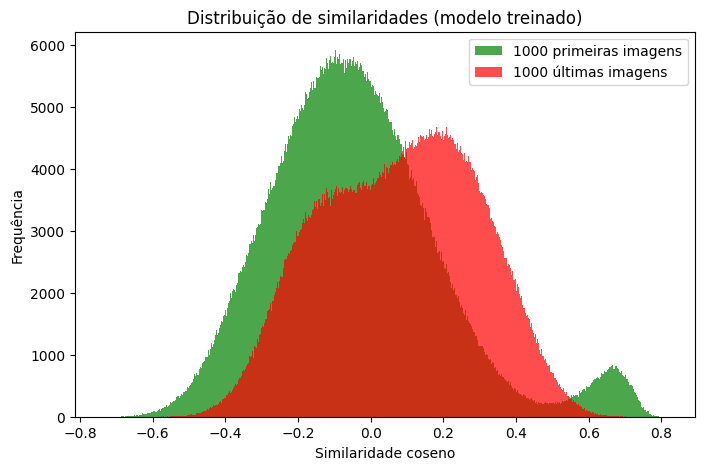

In [109]:
def compute_sims(model, ds, device="cpu"):
    model.eval()
    all_image_embs = []
    all_texts = []

    with torch.no_grad():
        for imgs, texts in ds:
            imgs = imgs.to(device).unsqueeze(0)
            all_image_embs.append(model.project_images(imgs))
            all_texts.append(texts)  # mantém lista de strings

        # concatena embeddings de todas as imagens
        image_embs = torch.cat(all_image_embs, dim=0)  # (num_images, dim)

        # codifica todos os textos
        text_embs = model.project_texts(all_texts).to(device)  # (num_texts, dim)

        # matriz de similaridade coseno
        sims = torch.matmul(image_embs, text_embs.T)  # (num_images, num_texts)

    return sims

# Calcula similaridades
sims = compute_sims(model, ds_train, device=device)

# Histograma comparando 1000 primeiras vs 1000 últimas imagens com todos os textos
sims_first1000 = sims[:1000].reshape(-1)
sims_last1000 = sims[-1000:].reshape(-1)

plt.figure(figsize=(8,5))
plt.hist(sims_first1000.cpu().numpy(), bins=1000, alpha=0.7, color="green", label="1000 primeiras imagens")
plt.hist(sims_last1000.cpu().numpy(), bins=1000, alpha=0.7, color="red", label="1000 últimas imagens")

plt.xlabel("Similaridade coseno")
plt.ylabel("Frequência")
plt.title("Distribuição de similaridades (modelo treinado)")
plt.legend()
plt.show()

In [110]:
sims.shape

torch.Size([2000, 2000])

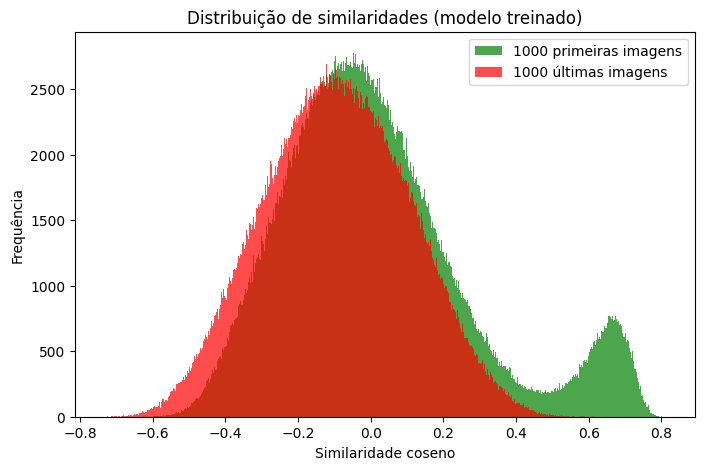

In [111]:
# Quadrante superior esquerdo x Quadrante superior direito
sims_first1000 = sims[:1000, :1000].reshape(-1)
sims_last1000 = sims[:1000, 1000:].reshape(-1)

plt.figure(figsize=(8,5))
plt.hist(sims_first1000.cpu().numpy(), bins=1000, alpha=0.7, color="green", label="1000 primeiras imagens")
plt.hist(sims_last1000.cpu().numpy(), bins=1000, alpha=0.7, color="red", label="1000 últimas imagens")

plt.xlabel("Similaridade coseno")
plt.ylabel("Frequência")
plt.title("Distribuição de similaridades (modelo treinado)")
plt.legend()
plt.show()

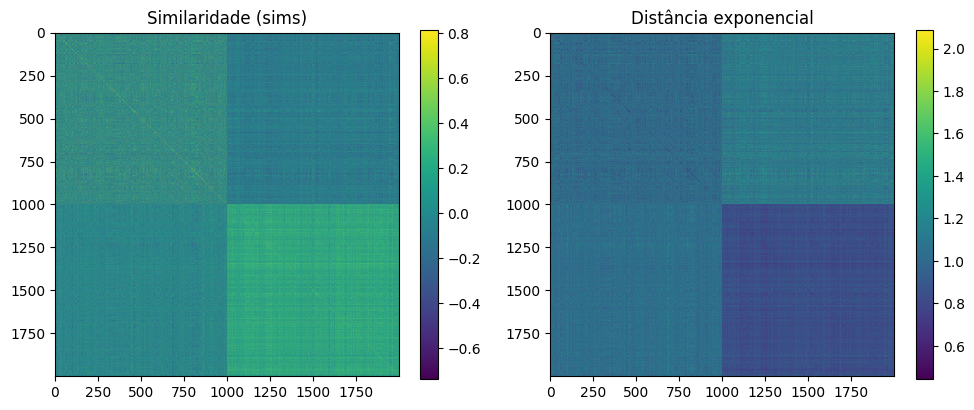

In [112]:
sims_plot = sims.detach().cpu()
dist_plot = torch.exp(-sims).detach().cpu()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 linha, 2 colunas

# Plot da similaridade
im0 = axes[0].imshow(sims_plot, cmap='viridis')
axes[0].set_title("Similaridade (sims)")
fig.colorbar(im0, ax=axes[0])

# Plot da distância exponencial
im1 = axes[1].imshow(dist_plot, cmap='viridis')
axes[1].set_title("Distância exponencial")
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

In [130]:
import random

#index[0-1000] = star
#index[1000-2000] = grid
rand_idx = random.randint(0,1000)
rand_idx

250

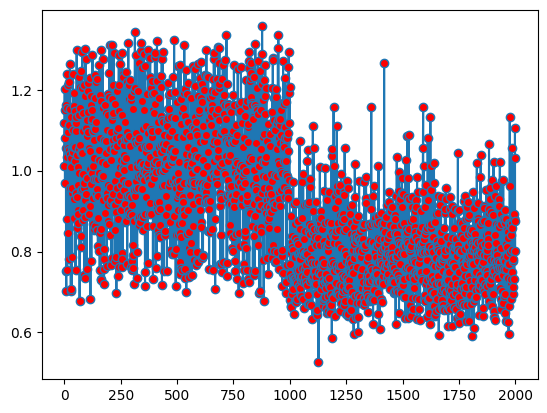

In [142]:
idx_ref = 1100
sims_img = sims[idx_ref]
plt.plot(torch.exp(-sims_img.cpu()), "-o", markerfacecolor="red")


In [143]:
def organize(idx_ref, sims, ds, columns):

    sims_img = sims[idx_ref, columns]
    idx_ord = torch.argsort(sims_img)
    #sims_img_ord = sims_img[idx_ord]
    ds_ord = [ds[columns.start+idx][0] for idx in idx_ord]

    return ds_ord

ds_star_ord = organize(idx_ref, sims, ds_train, slice(0, 1000))
ds_grid_ord = organize(idx_ref, sims, ds_train, slice(1000, 2000))

#print(ds_star_ord[:10])
#print(ds_star_ord[-10:])
#print(ds_grid_ord[:10])
#print(ds_grid_ord[-10:])

In [144]:
[ds_train[idx][1] for idx in range(1990, 2000)]

['0-4 0-5 0-10 1-11 2-5 2-8 3-6 3-8 4-7 5-7 5-11 6-9 8-11 9-10',
 '0-4 0-8 1-3 1-10 2-4 2-5 3-6 4-7 5-7 5-11 6-9 7-9 7-10 10-11',
 '0-5 0-8 0-10 1-9 2-5 2-7 2-10 3-8 3-10 4-5 4-7 6-7 6-11 9-10',
 '0-3 0-11 1-4 1-5 3-6 3-9 4-8 5-8 5-9 5-10 6-7 7-9 7-10 9-11',
 '0-2 0-5 0-7 0-9 1-5 1-10 2-6 3-7 3-9 4-10 5-11 6-7 8-11 9-11',
 '0-5 1-3 1-6 1-9 2-6 2-7 2-11 3-4 4-7 5-10 6-8 8-9 8-11 9-10',
 '0-3 0-7 1-4 1-5 1-11 2-10 3-5 5-8 5-9 6-8 6-9 7-10 8-10 9-11',
 '0-2 0-9 1-2 2-5 4-6 4-7 5-8 5-9 5-10 6-8 7-8 7-9 8-11 10-11',
 '0-1 0-5 1-3 1-7 2-4 2-7 2-9 3-10 4-11 5-7 5-9 7-10 8-10 9-11',
 '0-2 0-3 1-4 1-10 1-11 3-5 4-7 4-8 5-9 5-10 6-9 6-11 7-10 8-11']

In [145]:
def sim_img_alltext(model, image, ds, device="cpu"):
    model.eval()
    all_texts = []

    with torch.no_grad():
        for _, texts in ds:
            all_texts.append(texts)  # mantém lista de strings

        img_emb = model.project_images(image.unsqueeze(0).to(device))

        # codifica todos os textos
        text_embs = model.project_texts(all_texts).to(device)  # (num_texts, dim)

        # matriz de similaridade coseno
        sims = torch.matmul(img_emb, text_embs.T)  # (num_images, num_texts)

    return sims

In [146]:
ds, _ = get_dataset("../Graphs/data/images", "../Graphs/data/edgelists.json", split=0)

In [147]:
len(ds)

2000

/tmp/ipykernel_66859/610776573.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


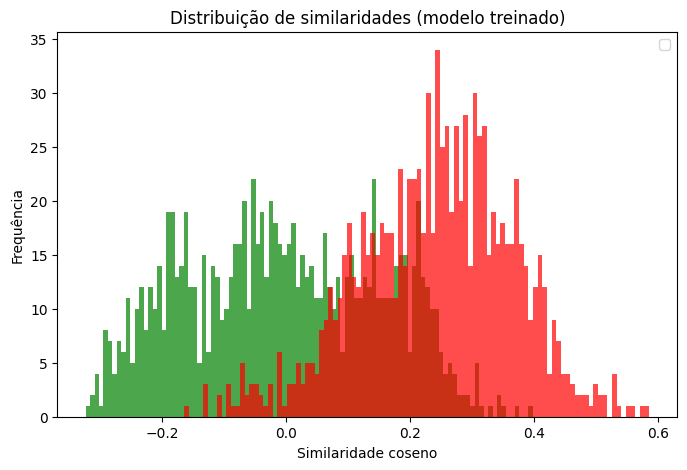

In [148]:
image, _ = ds[idx_ref]
sims2 = sim_img_alltext(model, image, ds, device=device)

sims_first1000 = sims2[0,:1000].reshape(-1)
sims_last1000 = sims2[0,1000:].reshape(-1)

plt.figure(figsize=(8,5))
plt.hist(sims_first1000.cpu().numpy(), bins=100, alpha=0.7, color="green")
plt.hist(sims_last1000.cpu().numpy(), bins=100, alpha=0.7, color="red")


plt.xlabel("Similaridade coseno")
plt.ylabel("Frequência")
plt.title("Distribuição de similaridades (modelo treinado)")
plt.legend()
plt.show()

In [149]:
sims2.shape

torch.Size([1, 2000])

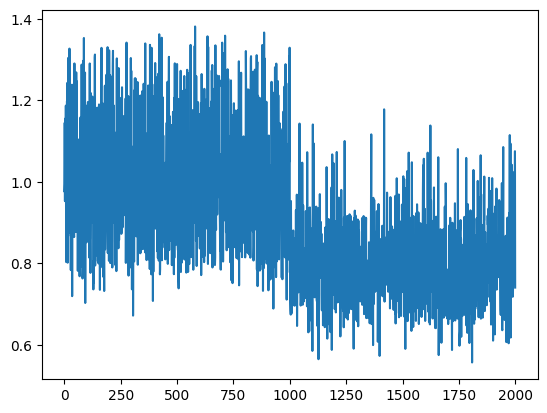

In [150]:
plt.plot(torch.exp(-sims2[0].cpu()))

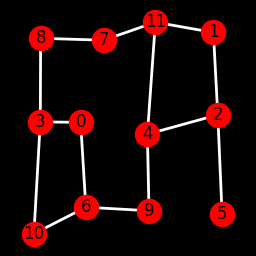

'0-3 0-6 1-2 1-11 2-4 2-5 3-8 3-10 4-9 4-11 6-9 6-10 7-8 7-11'

In [151]:
ds.transform = None
display(*ds[idx_ref])

'------estrelas menos similares--------'

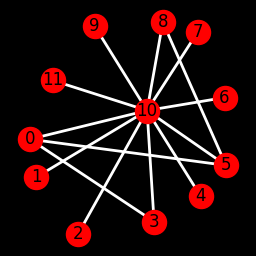

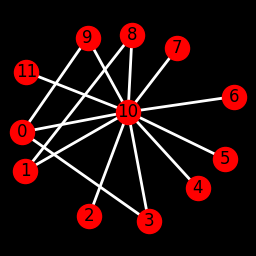

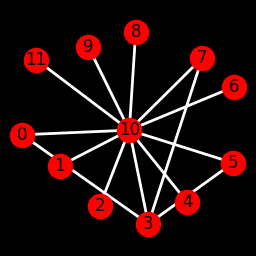

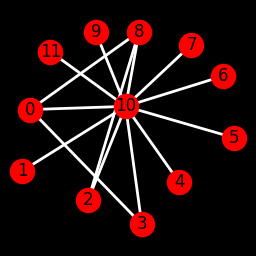

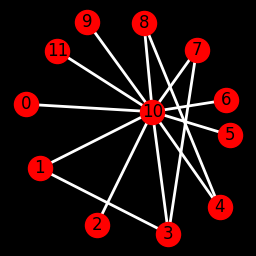

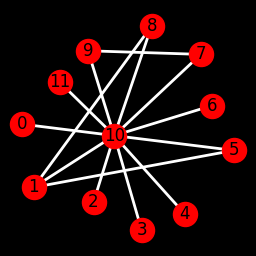

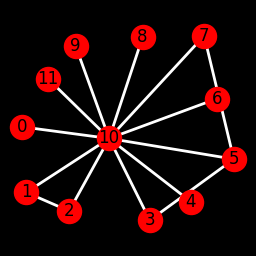

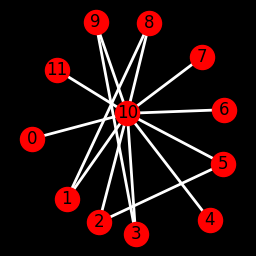

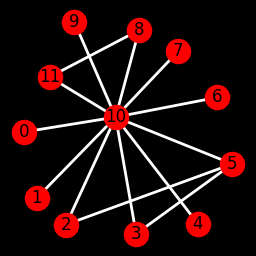

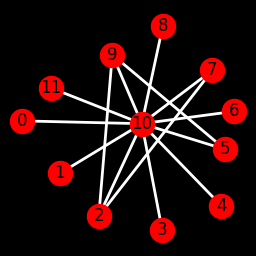

'------estrelas mais similares--------'

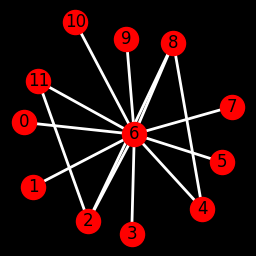

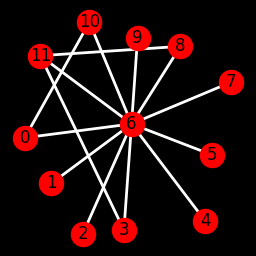

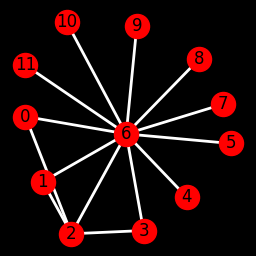

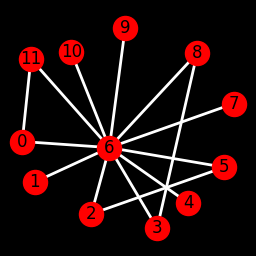

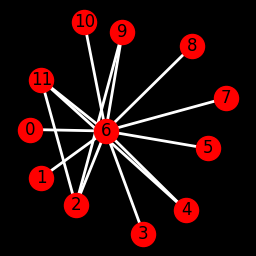

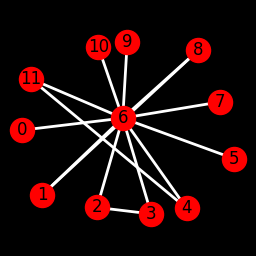

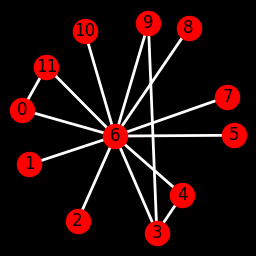

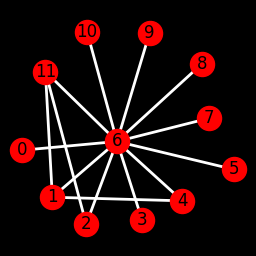

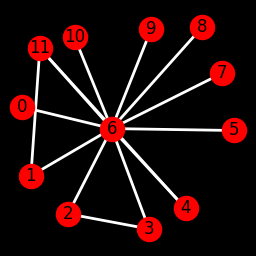

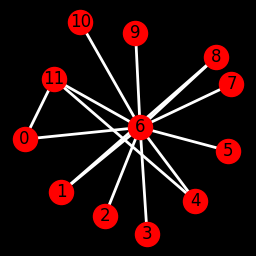

'------grids menos similares--------'

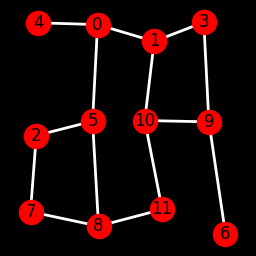

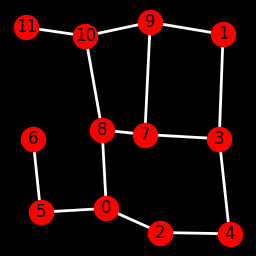

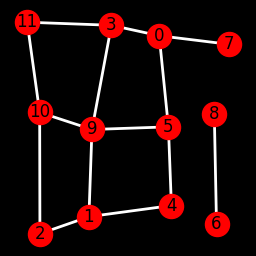

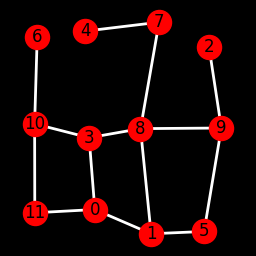

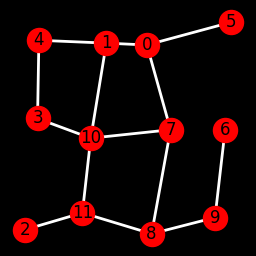

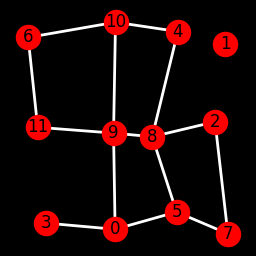

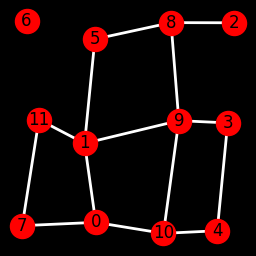

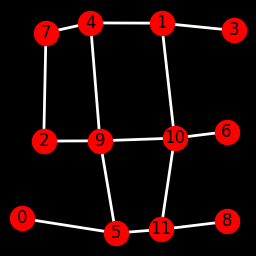

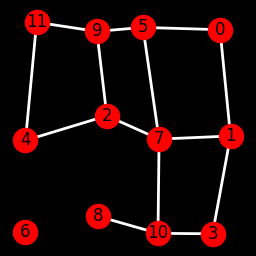

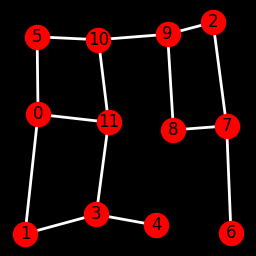

'------grids mais similares--------'

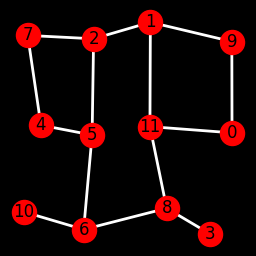

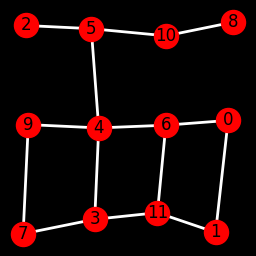

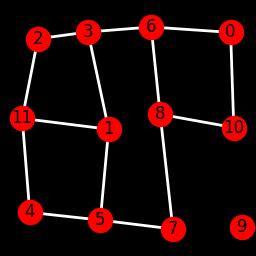

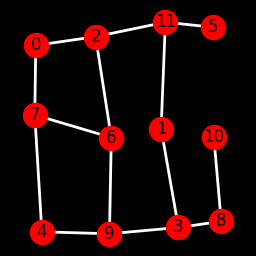

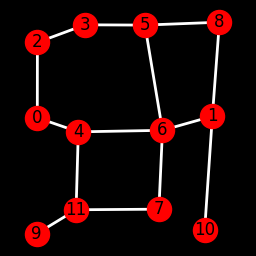

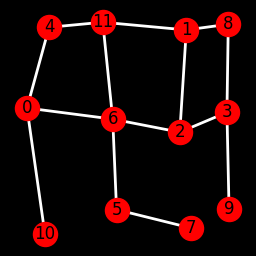

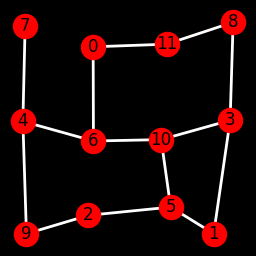

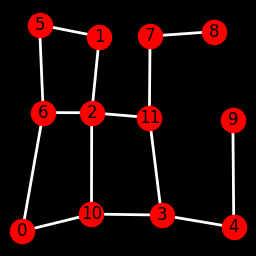

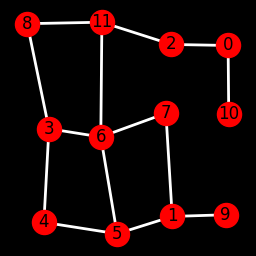

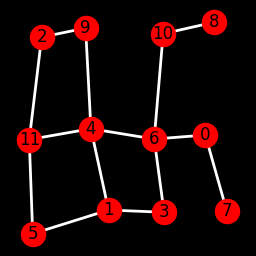

In [152]:
def organize(idx_ref, sims, ds, columns):

    sims_img = sims[idx_ref, columns]
    idx_ord = torch.argsort(sims_img)
    #sims_img_ord = sims_img[idx_ord]
    ds_ord = [ds[columns.start+idx][0] for idx in idx_ord]

    return ds_ord

ds_star_ord = organize(idx_ref, sims, ds, slice(0, 1000))
ds_grid_ord = organize(idx_ref, sims, ds, slice(1000, 2000))

display("------estrelas menos similares--------", *ds_star_ord[:10])
display("------estrelas mais similares--------", *ds_star_ord[-10:])
display( "------grids menos similares--------", *ds_grid_ord[:10])
display("------grids mais similares--------", *ds_grid_ord[-10:])